## Forecasting - predicting the future

In time series we expect patterns to persist as we progress through time.

Find the pattern, selecting the correct model

Predict the future.

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
raw_data = yfinance.download(tickers='^GSPC ^FTSE ^N225 ^GDAXI', start='1994-01-07', end='2021-10-27', interval='1d', group_by='ticker', auto_adjust=True, threads=True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [6]:
# Creating returns
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [7]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1]) * 100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1]) * 100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1]) * 100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1]) * 100

In [8]:
# Splitting the data
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [9]:
# Fitting a model

model_ar = ARIMA(df.ftse, order=(1,0,0))
results_ar = model_ar.fit()

In [10]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2016-03-29,2055.010010,9887.940430,6105.899902,17103.529297,0.881665,-0.009827,0.371430,-0.179988,77.149877,6.271320,16512.116619,-10.212288
2016-03-30,2063.949951,10046.610352,6203.200195,16878.960938,0.435032,1.593545,1.604681,-1.312994,38.067318,-1016.936499,71337.042401,-74.497524
2016-03-31,2059.739990,9965.509766,6174.899902,16758.669922,-0.203976,-0.456221,-0.807243,-0.712668,-17.848859,291.141759,-35886.472105,-40.435842
2016-04-01,2072.780029,9794.639648,6146.100098,16164.160156,0.633092,-0.466401,-1.714615,-3.547476,55.398504,297.638418,-76224.209897,-201.278996
2016-04-04,2066.129883,9822.080078,6164.700195,16123.269531,-0.320832,0.302633,0.280158,-0.252971,-28.074339,-193.127875,12454.571156,-14.353229


In [11]:
# Create variables that will help us change the periods easily instead of typing them every time
start_date = '2016-04-05'
end_date = '2017-01-01'
df_pred = results_ar.predict(start=start_date, end=end_date)

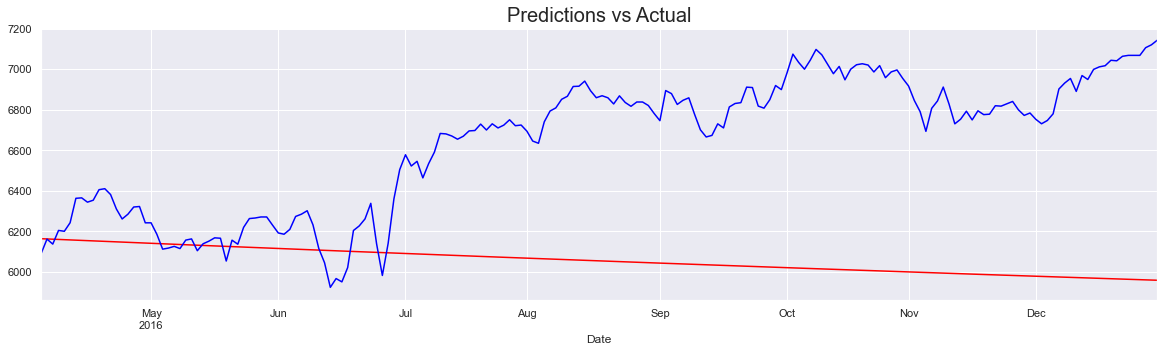

In [12]:
df_pred[start_date:end_date].plot(figsize=(20, 5), color='red')
df_test.ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual', size=20)
plt.show()
# the falling prediction comes from our model of choice
# the predictions are only based on the constant and the prices from the previous period
# AR model is bad at estimating non-stationary data

## Forecasting returns with AR and MA

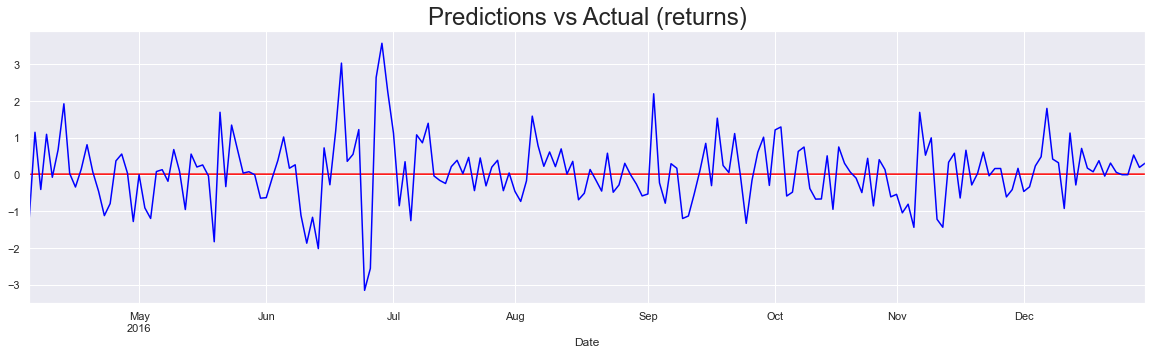

In [13]:
end_date = '2017-01-01'
model_ret_ar = ARIMA(df.ret_ftse[1:], order=(1,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start=start_date, end=end_date)

df_pred_ar[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual (returns)', size=24)
plt.show()

# model makes no predictions since it assumes all future returns will be 0, or extremely close to it

In [14]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5801
Model:                     ARMA(1, 0)   Log Likelihood               -9013.809
Method:                       css-mle   S.D. of innovations              1.144
Date:                Tue, 02 Nov 2021   AIC                          18033.617
Time:                        20:41:24   BIC                          18053.615
Sample:                    01-10-1994   HQIC                         18040.574
                         - 04-04-2016                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0166      0.015      1.129      0.259      -0.012       0.045
ar.L1.ret_ftse    -0.0231      0.013     -1.762      0.078      -0.049       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.2345           +0.0000j           43.2345            0.5000
-----------------------------------------------------------------------------
"""

## MA

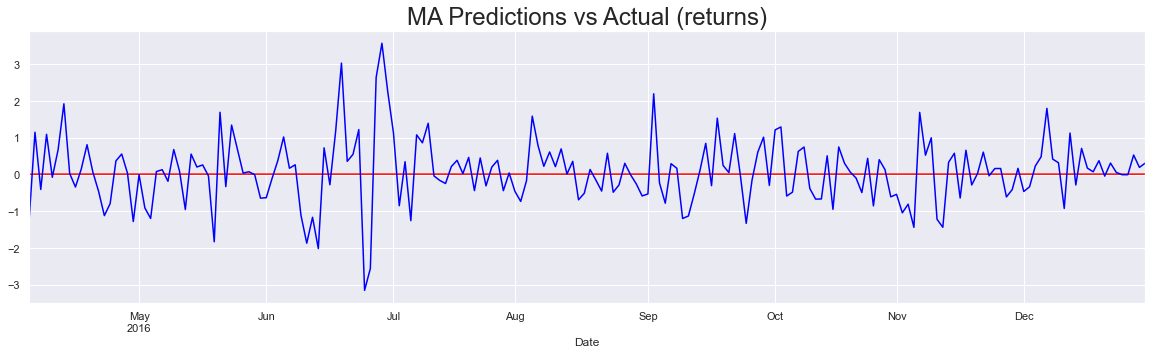

In [15]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start=start_date, end=end_date)

df_pred_ma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('MA Predictions vs Actual (returns)', size=24)
plt.show()

In [16]:
df_pred_ma.head()

2016-04-05    0.009539
2016-04-06    0.016582
2016-04-07    0.016582
2016-04-08    0.016582
2016-04-11    0.016582
Freq: B, dtype: float64

## ARMA

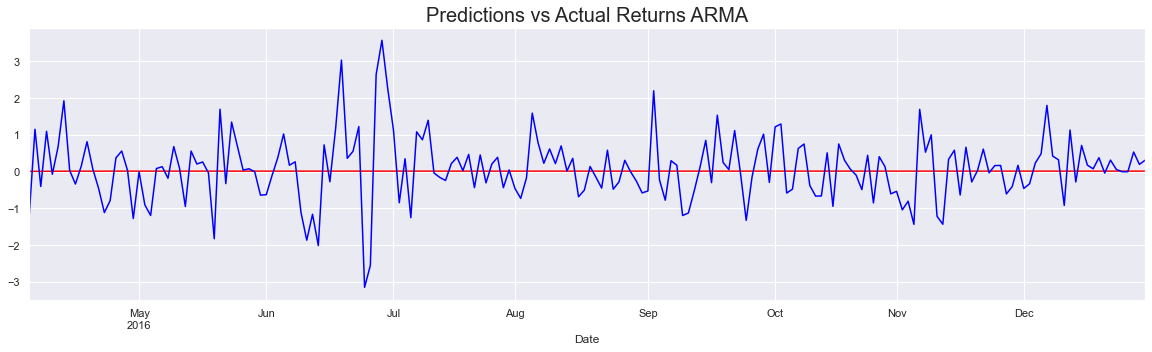

In [17]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start=start_date, end=end_date)

df_pred_arma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual Returns ARMA', size=20)
plt.show()

In [18]:
df_pred_arma.head()

2016-04-05    0.009538
2016-04-06    0.010939
2016-04-07    0.012061
2016-04-08    0.012962
2016-04-11    0.013684
Freq: B, dtype: float64

In [19]:
df_pred_arma.tail()

2016-12-27    0.016606
2016-12-28    0.016606
2016-12-29    0.016606
2016-12-30    0.016606
2017-01-02    0.016606
Freq: B, dtype: float64

## ARMAX

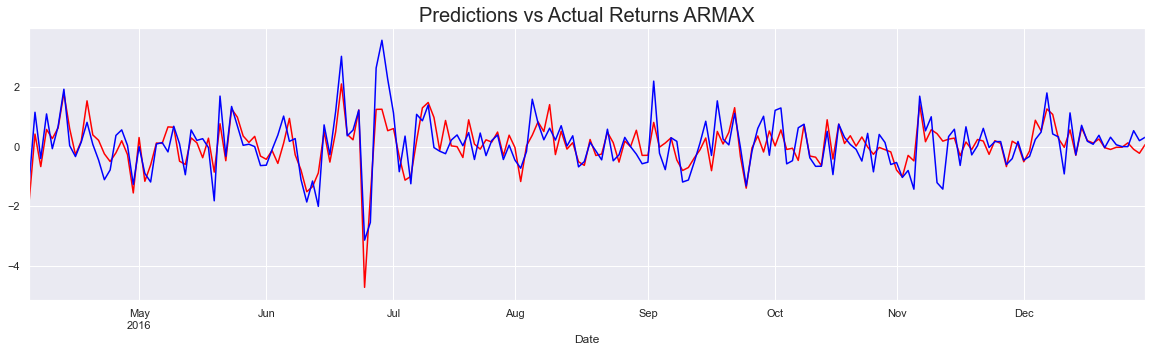

In [20]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_armax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual Returns ARMAX', size=20)
plt.show()

# MAX models can be great when analyzing data, but poor when trying to forecast it

## SARMA

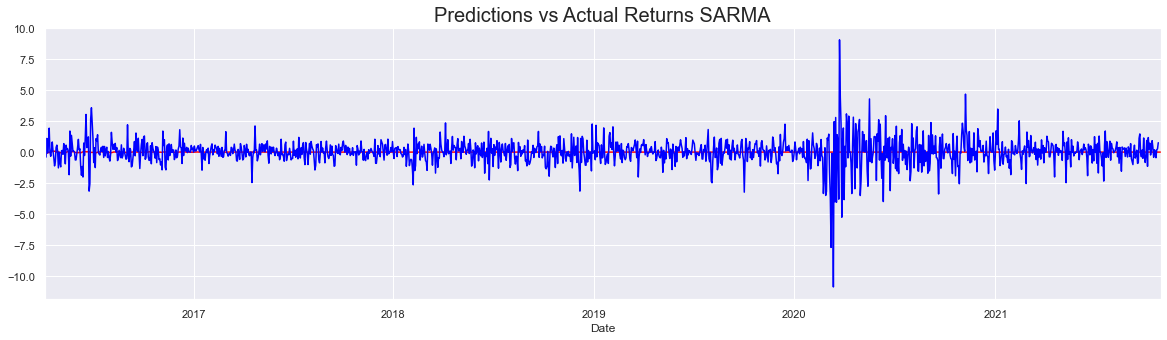

In [21]:
end_date='2021-10-31'
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start=start_date, end=end_date)

df_pred_sarma[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual Returns SARMA', size=20)
plt.show()

# SARMA models anticipate greater stability than the earlier MAX model
# SARMA accuracy is lacking

## SARIMAX

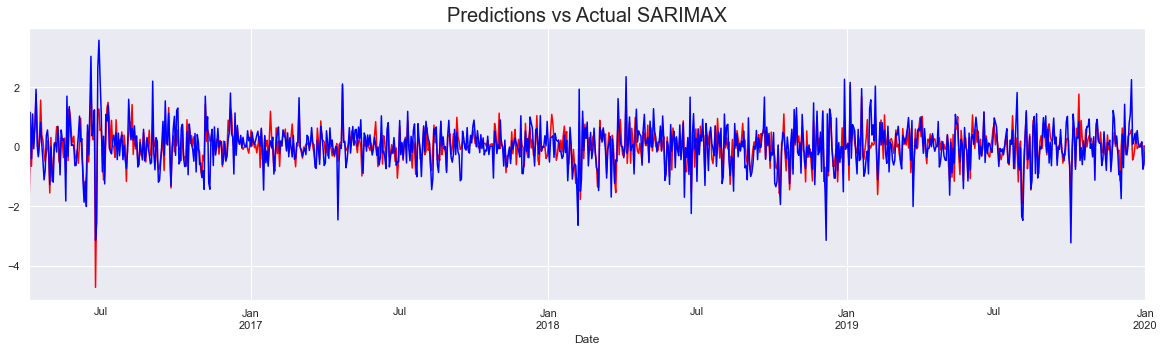

In [24]:
end_date = '2020-01-01'
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order=(3,0,4), seasonal_order=(3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])

df_pred_sarimax[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Predictions vs Actual SARIMAX', size=20)
plt.show()

## Auto ARIMA forecasting

In [26]:
model_auto = auto_arima(df.ret_ftse[1:])

In [27]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date])), index=df_test[start_date:end_date].index)

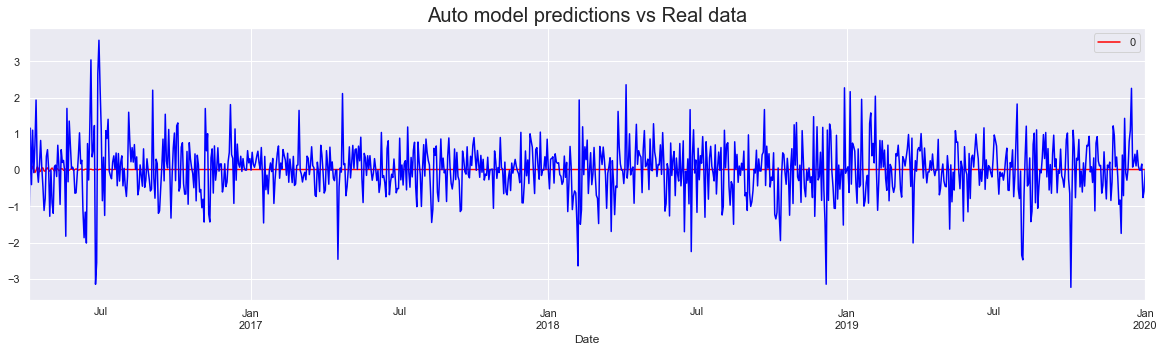

In [28]:
df_auto_pred.plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Auto model predictions vs Real data', size=20)
plt.show()

# the default "best" model

In [29]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous=df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m=5, max_p=5, max_q=5, max_P=5, max_Q=5)

In [30]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=len(df_test[start_date:end_date]), exogenous=df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]), index=df_test[start_date:end_date].index)

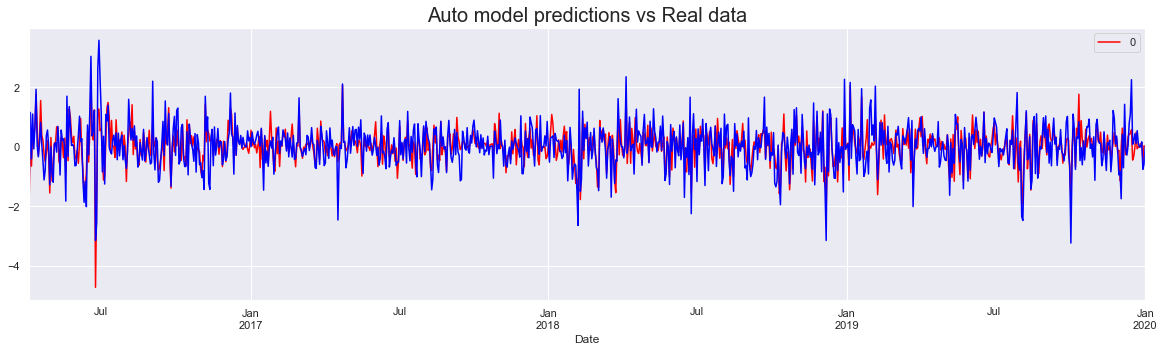

In [31]:
df_auto_pred.plot(figsize=(20,5), color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.title('Auto model predictions vs Real data', size=20)
plt.show()

# As long as we provide the auto_arima method with enough information, it's bound to give us a reasonable solution

## Comparing all the models

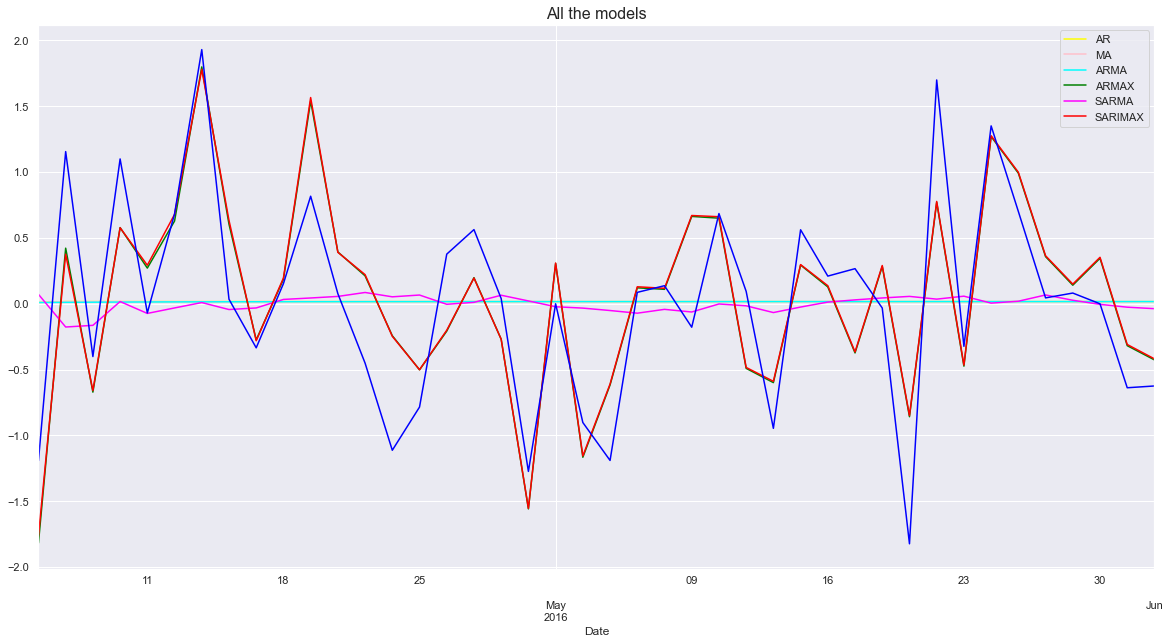

In [35]:
end_date = '2016-06-01'
df_pred_ar[start_date:end_date].plot(figsize=(20,10), color='yellow')
df_pred_ma[start_date:end_date].plot(color='pink')
df_pred_arma[start_date:end_date].plot(color='cyan')
df_pred_armax[start_date:end_date].plot(color='green')
df_pred_sarma[start_date:end_date].plot(color='magenta')
df_pred_sarimax[start_date:end_date].plot(color='red')
df_test.ret_ftse[start_date:end_date].plot(color='blue')
plt.legend(['AR', 'MA', 'ARMA', 'ARMAX', 'SARMA', 'SARIMAX'])
plt.title('All the models', size=16)
plt.show()

## Forecasting volatility with ARCH and GARCH

In [36]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol='GARCH', p=1, q=1, mean='constant', dist='Normal')
res_garch = mod_garch.fit(last_obs=start_date, update_freq=10)

Iteration:     10,   Func. Count:     66,   Neg. LLF: 7944.153429156819
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7944.153429156819
            Iterations: 11
            Function evaluations: 70
            Gradient evaluations: 11


In [38]:
pred_garch = res_garch.forecast(horizon=1, align='target')
# horizon - how many observations we want our model to predict for each date
# align - determines whether we match the value with the date the prediction is made on, or the one it's supposed to represent

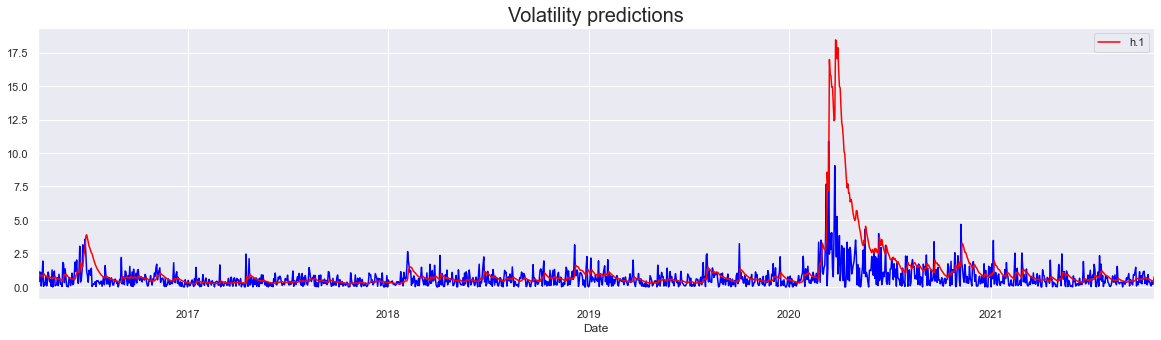

In [41]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), color='red', zorder=2)
df_test.ret_ftse.abs().plot(color='blue', zorder=1)
plt.title('Volatility predictions', size=20)
plt.show()

In [42]:
pred_garch = res_garch.forecast(horizon=100, align='target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-26,0.3961,0.42912,0.466096,0.484608,0.526891,0.57021,0.599243,0.639854,0.622661,0.671542,...,1.030022,1.040924,0.90818,0.911679,0.923991,0.933527,0.946939,0.947066,0.961399,0.974486


## Multivariate regression

Regressions stacked on top of one another.

Multivariate models:

Vector - every component contains a value for each of the time series

In [43]:
from statsmodels.tsa.api import VAR

In [44]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [45]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic='aic')

In [46]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Nov, 2021
Time:                     21:50:10
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.260942
Nobs:                     5796.00    HQIC:                  0.197951
Log likelihood:          -33289.0    FPE:                    1.17863
AIC:                     0.164349    Det(Omega_mle):         1.16170
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.037302         0.015295            2.439           0.015
L1.ret_spx           -0.106551         0.016825           -6.333           0.000
L1.ret_dax            0.059140         0.018068           

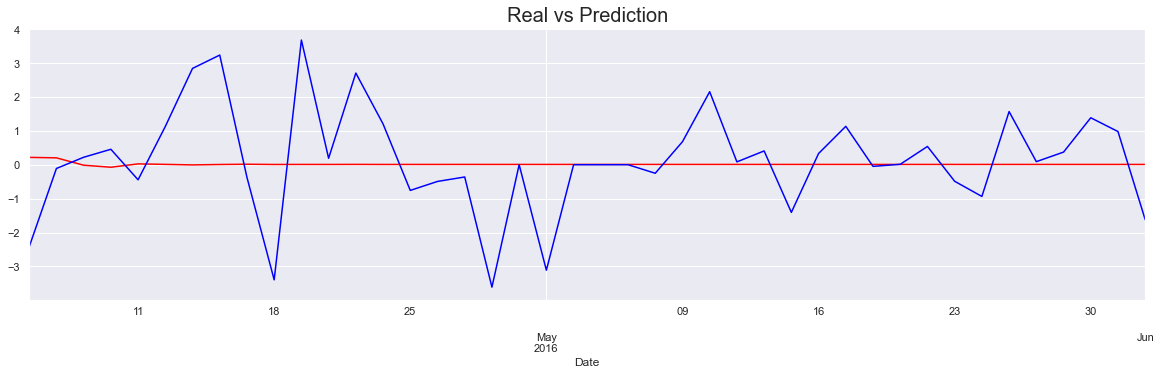

In [51]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data=var_pred_ret, index=df_test[start_date:end_date].index, columns=df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize=(20,5), color='red')
df_test.ret_nikkei[start_date:end_date].plot(color='blue')
plt.title('Real vs Prediction', size=20)
plt.show()

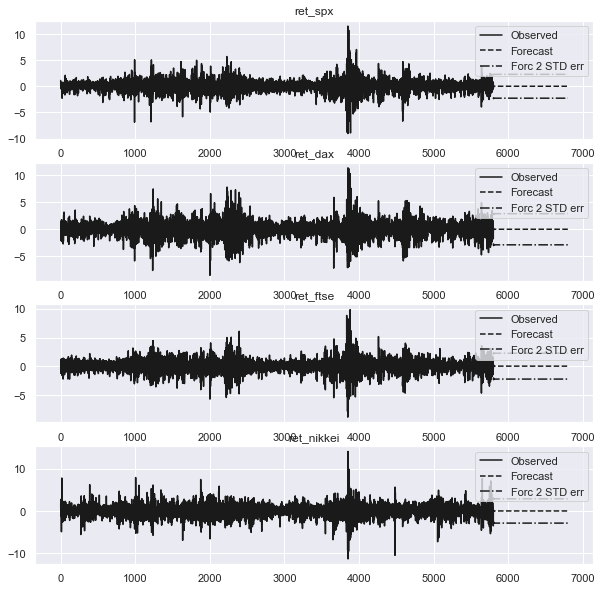

In [52]:
results_var_ret.plot_forecast(1000)
plt.show()